In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
from sklearn.decomposition import PCA, IncrementalPCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
ROWS = 64
COLS = 64
CHANNELS = 3
CLASSES = 2

In [17]:
file_path=train_images[0]

'/content/drive/MyDrive/Flood classification/actual/train/flood909960364967776256_0.jpg'

In [14]:
def read_image(file_path):
    # reading image
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    # normalization of image
    norm = np.zeros((ROWS,COLS))
    norm_img=cv2.normalize(img, norm, 0, 255, cv2.NORM_MINMAX)
    # pca transformation
    pca = PCA()
    # pca.fit(norm_img)
    # resizing and returning the image
    return cv2.resize(norm_img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prepare_data(images):
    m = len(images)
    X = np.zeros((m, ROWS, COLS, CHANNELS), dtype=np.uint8)
    y = np.zeros((1, m), dtype=np.uint8)
    for i, image_file in enumerate(images):
        img=image_file.split('/')[-1]
        X[i,:] = read_image(image_file)
        if 'flood' in img.lower():
            y[0, i] = 1
        elif 'normal' in img.lower():
            y[0, i] = 0
    return X, y

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [15]:
TRAIN_DIR="/content/drive/MyDrive/Flood classification/actual/train"
TEST_DIR="/content/drive/MyDrive/Flood classification/actual/validation"
predict_dir="/content/drive/MyDrive/Flood classification/actual/test"

train_images = [TRAIN_DIR+"/"+i for i in os.listdir(TRAIN_DIR)]
test_images =  [TEST_DIR+"/"+i for i in os.listdir(TEST_DIR)]
predict_images =  [predict_dir+"/"+i for i in os.listdir(predict_dir)]

train_set_x, train_set_y = prepare_data(train_images)
test_set_x, test_set_y = prepare_data(test_images)
predict_set_x, predict_set_y = prepare_data(predict_images)

X_train = train_set_x/255
X_test = test_set_x/255
X_predict = predict_set_x/255

Y_train = convert_to_one_hot(train_set_y, CLASSES).T
Y_test = convert_to_one_hot(test_set_y, CLASSES).T

KeyboardInterrupt: ignored

In [ ]:
print ("number of training examples =", X_train.shape[0])
print ("number of test examples =", X_test.shape[0])
print ("X_train shape:", X_train.shape)
print ("Y_train shape:", Y_train.shape)
print ("X_test shape:", X_test.shape)
print ("Y_test shape:", Y_test.shape)

number of training examples = 556
number of test examples = 185
X_train shape: (556, 64, 64, 3)
Y_train shape: (556, 2)
X_test shape: (185, 64, 64, 3)
Y_test shape: (185, 2)


In [ ]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = identity_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = ", out[0][1][1][0])

out =  [1.1134045  0.09321678 0.         0.95603985 0.5349631  0.        ]


In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

with tf.compat.v1.Session() as test:
    A_prev = tf.compat.v1.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = convolutional_block(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.compat.v1.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = ",out[0][1][1][0])

out =  [0.         0.7096634  3.001288   0.         2.1703773  0.47939327]


In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
model = ResNet50(input_shape = (ROWS, COLS, CHANNELS), classes = CLASSES)

In [ ]:
import time
from tensorflow import keras
root_logdir = os.path.join(os.curdir, "logs\\fit\\")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc',f1_m,precision_m, recall_m])

In [ ]:
# Experimenting on epoch with constant batch size

In [ ]:
# history=model.fit(X_train, Y_train, epochs = 20, batch_size = 20,validation_data=(X_test, Y_test),validation_freq=1,callbacks=[tensorboard_cb])
history=model.fit(X_train, Y_train, epochs = 20, batch_size = 10,validation_data=(X_test, Y_test))

Epoch 1/20
56/56 [==============================] - 9s 63ms/step - loss: 2.1957 - acc: 0.5198 - f1_m: 0.5208 - precision_m: 0.5208 - recall_m: 0.5208 - val_loss: 0.6950 - val_acc: 0.5351 - val_f1_m: 0.5316 - val_precision_m: 0.5316 - val_recall_m: 0.5316
Epoch 2/20
56/56 [==============================] - 2s 43ms/step - loss: 0.8458 - acc: 0.6475 - f1_m: 0.6476 - precision_m: 0.6476 - recall_m: 0.6476 - val_loss: 1.0558 - val_acc: 0.4649 - val_f1_m: 0.4684 - val_precision_m: 0.4684 - val_recall_m: 0.4684
Epoch 3/20
56/56 [==============================] - 3s 50ms/step - loss: 0.9038 - acc: 0.7068 - f1_m: 0.7077 - precision_m: 0.7077 - recall_m: 0.7077 - val_loss: 1.5924 - val_acc: 0.4649 - val_f1_m: 0.4684 - val_precision_m: 0.4684 - val_recall_m: 0.4684
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.0064 - acc: 0.7284 - f1_m: 0.7280 - precision_m: 0.7280 - recall_m: 0.7280 - val_loss: 0.7669 - val_acc: 0.5297 - val_f1_m: 0.5263 - val_precision_m: 0.5263 - v

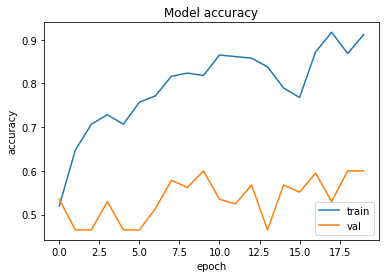

In [ ]:
import matplotlib.pyplot as plot

# plot.subplot(2,1,1)
plot.plot(history.history['acc'])
plot.plot(history.history['val_acc'])
plot.title('Model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'val'], loc='lower right')

In [ ]:
model.metrics_names

['loss', 'acc', 'f1_m', 'precision_m', 'recall_m']

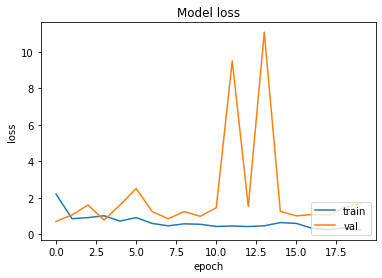

In [ ]:
# Loss
import matplotlib.pyplot as plot

# plot.subplot(2,1,1)
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('Model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'val'], loc='lower right')

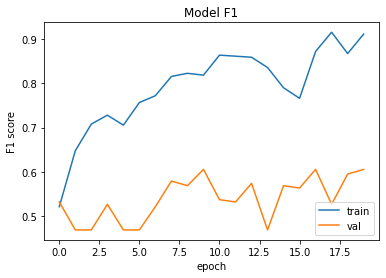

In [ ]:
# F1 score
import matplotlib.pyplot as plot

plot.plot(history.history['f1_m'])
plot.plot(history.history['val_f1_m'])
# plot.figure(6,3)
plot.title('Model F1')
plot.ylabel('F1 score')
plot.xlabel('epoch')
plot.legend(['train', 'val'], loc='lower right')

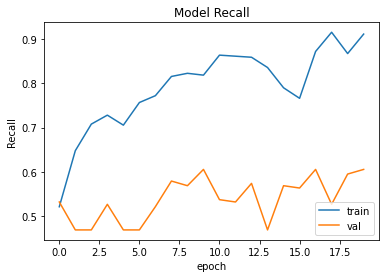

In [ ]:
# Recall
import matplotlib.pyplot as plot

# plot.subplot(2,1,1)
plot.plot(history.history['recall_m'])
plot.plot(history.history['val_recall_m'])
plot.title('Model Recall')
plot.ylabel('Recall')
plot.xlabel('epoch')
plot.legend(['train', 'val'], loc='lower right')

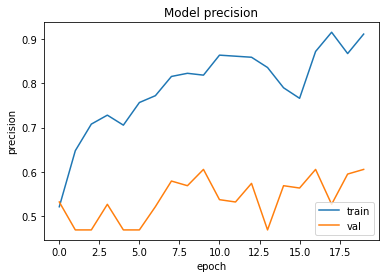

In [ ]:
# Precision
import matplotlib.pyplot as plot

# plot.subplot(2,1,1)
plot.plot(history.history['precision_m'])
plot.plot(history.history['val_precision_m'])
plot.title('Model precision')
plot.ylabel('precision')
plot.xlabel('epoch')
plot.legend(['train', 'val'], loc='lower right')

In [ ]:
# Predict
y_proba=model.predict(X_predict)
len(y_proba)

6/6 [==============================] - 0s 30ms/step


186

In [ ]:
# Exporting the file to drive back
import pandas as pd

predictions=pd.DataFrame(y_proba,columns=['predictions_normal','predictions_flood'])
predictions['image_path']=predict_images
predictions.to_csv("/content/drive/MyDrive/Flood classification/actual/output/predictions.csv",index=False)

In [ ]:
model.save('ResNet50.h5')

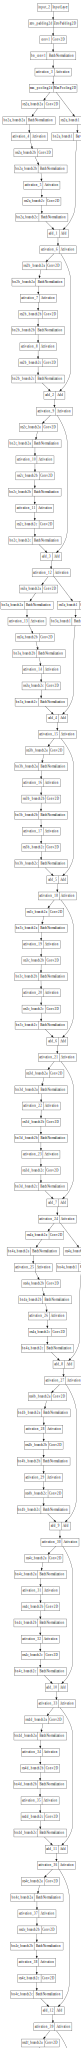

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))